Use the previously saved ckpt.pth file in training to load the Modified ResNet for inference on both the CIFAR10 official test set and the customized test set in Kaggle competition. Has to use GPU to load the ckpt.pth file if previously trained the model with GPU.

A sample ckpt.pth file is provided in the ```./checkpoint``` folder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

import os
import argparse
import sys
from google.colab import files

import pickle
import numpy as np
import matplotlib.pyplot as plt

## Load Model
First define model as in training session: Blocks->Net->model.

Setups has to be exactly the same as the in the training book ```ModifiedResNet_CIFAR.ipynb```.

Here the modified shortcut is turned on to match the sample model provided.

To turn it off, comment the following lines where ```self.shortcut``` is defined in both the BasicBlock and the PreActBlock,
```
                nn.MaxPool2d(3, stride = stride, padding = 1),
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=1, bias=False),
```
and uncomment out the following lines.
```
                # nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
```


In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First Convolutional Layer:
        # Kernel(Filter) Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(planes)

        # Second Convolutional Layer:
        # Kernel Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # Batch Normalization
        self.bn2 = nn.BatchNorm2d(planes)

        # When the input and output dimensions do not match up,
        # use 1x1 convolutional layer to adjust the number of channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.MaxPool2d(3, stride = stride, padding = 1),
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=1, bias=False),
                # nn.Conv2d(in_planes, self.expansion*planes,
                #           kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # print("shape after first weight layer:", out.shape)
        out = self.bn2(self.conv2(out))
        # print("shape after second weight layer:", out.shape)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class PreActBlock(nn.Module):
    expansion = 1
    # Full Pre-activation:
    # BatchNorm -> Relu -> Conv -> BatchNorm -> Relu -> Conv
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()

        # First Batch Normalization
        self.bn1 = nn.BatchNorm2d(in_planes)
        # First Convolutional Layer:
        # Kernel(Filter) Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        # Second Batch Normalization
        self.bn2 = nn.BatchNorm2d(planes)
        # Second Convolutional Layer:
        # Kernel Size: 3 x 3
        # Stride: 1
        # Padding: 1 (keep the output size equal to the input size if stride is 1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)


        # When the input and output dimensions do not match up,
        # use 1x1 convolutional layer to adjust the number of channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.MaxPool2d(3, stride = stride, padding = 1),
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=1, bias=False),
                # nn.Conv2d(in_planes, self.expansion*planes,
                #           kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        # bn-> relu -> conv
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        # print("shape after first weight layer:", out.shape)
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        # print("shape after second weight layer:", out.shape)
        out += self.shortcut(x)
        return out

Here the Input Layer Convolution is turned off to match the sample model provided.

To turn the Convolution back on, change ```kernel_size``` from 1 to 3 and ```padding``` from 0 to 1 when defining ```self.conv1```, and do it backwards to turn if off.

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=1,
                               stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

To match the provided sample, ```PreActBlock``` is used below and the model structure is of (32, [8,6,4,3])

In [5]:
def ModifiedResNet():
    return ResNet(PreActBlock, [8, 6, 4, 3])

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('==> Building model..')

net = ModifiedResNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


## Load and Prepare Datasets
Then upload the saved ckpt.pth to checkpoint folder.

In [7]:
if not os.path.isdir('checkpoint'):
  os.mkdir('./checkpoint')
# upload the ckpt.pth file for the model you would like to use
uploaded = files.upload()
os.rename('ckpt.pth','./checkpoint/ckpt.pth')

Saving ckpt.pth to ckpt.pth


In [8]:
if device == 'cuda':
  checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

Load data from the provided file: one from the official test set (test_batch), the other from the customized test set (cifar_test_nolabels.pkl) provided by course staff. Make them tensor datasets and dataloaders. Both of them downloaded and stored in Google Drive.

In [9]:
!gdown 1QvbvlZwjW8G-4qDeyFJ6LHu55FJw8UGt #test_batch
!gdown 1HhmSG8MmoSHYggm_5Euo6JT1w8Gq-boW #cifar_test_nolabels.pkl

Downloading...
From: https://drive.google.com/uc?id=1QvbvlZwjW8G-4qDeyFJ6LHu55FJw8UGt
To: /content/test_batch
100% 31.0M/31.0M [00:00<00:00, 76.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HhmSG8MmoSHYggm_5Euo6JT1w8Gq-boW
To: /content/cifar_test_nolabels.pkl
100% 30.8M/30.8M [00:00<00:00, 95.6MB/s]


In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def cifar10_plot(data, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))

    print("shape: ", img.shape)
    # print("label: ", data[b'labels'][im_idx])
    # print("category:", meta[b'label_names'][data[b'labels'][im_idx]])

    plt.imshow(img)
    plt.show()


In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)

        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)

        return x, y

Dataset and dataloader marked with 'nolabel' is for the customized dataset, 'official' is for the actual CIFAR test dataset.

In [12]:
test_nolabel = unpickle("cifar_test_nolabels.pkl")
test_data_nolabel = np.transpose(np.reshape(test_nolabel[b'data'],(-1, 3, 32, 32)),(0,2,3,1))
test_dataID_nolabel = test_nolabel[b'ids']

test_official = unpickle("test_batch")
test_data_official = np.transpose(np.reshape(test_official[b'data'],(-1, 3, 32, 32)),(0,2,3,1))
test_label_official = test_official[b'labels']


Take a look at the image loded

shape:  (32, 32, 3)


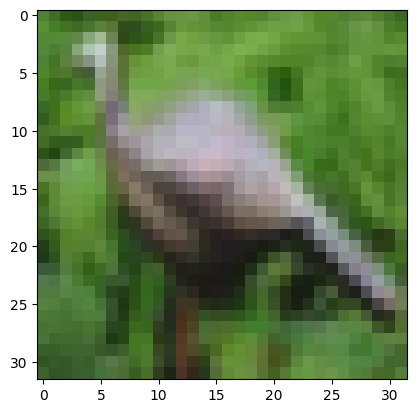

In [13]:
cifar10_plot(test_nolabel,1001)

In [14]:
# Use the same standarization on the test set as the training set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_nolabel_dataset = MyDataset(test_data_nolabel, test_dataID_nolabel, transform = transform_test)
test_official_dataset = MyDataset(test_data_official, test_label_official, transform = transform_test)

testloader_oset = torch.utils.data.DataLoader(
    test_official_dataset, batch_size=100, shuffle=False)

testloader_nset = torch.utils.data.DataLoader(
    test_nolabel_dataset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
image, label = next(iter(testloader_oset))
print(image.shape)

torch.Size([100, 3, 32, 32])


# Run Inference
First inference on the official test set to see if it matches the result from the training book

In [18]:
criterion = nn.CrossEntropyLoss()

def test(testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                print(batch_idx, len(testloader), 'Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        print("Total accuracy for official test set: %.3f %%"%(100.*correct/total))


In [19]:
test(testloader_oset)

0 100 Loss: 0.137 | Test Acc: 97.000% (97/100)
10 100 Loss: 0.204 | Test Acc: 95.364% (1049/1100)
20 100 Loss: 0.231 | Test Acc: 94.619% (1987/2100)
30 100 Loss: 0.238 | Test Acc: 94.839% (2940/3100)
40 100 Loss: 0.233 | Test Acc: 94.927% (3892/4100)
50 100 Loss: 0.234 | Test Acc: 94.980% (4844/5100)
60 100 Loss: 0.225 | Test Acc: 95.131% (5803/6100)
70 100 Loss: 0.215 | Test Acc: 95.197% (6759/7100)
80 100 Loss: 0.217 | Test Acc: 95.123% (7705/8100)
90 100 Loss: 0.212 | Test Acc: 95.242% (8667/9100)
Total accuracy for official test set: 95.250 %


All look good. Now apply on the no label dataset and make the Submission.csv file - note here the "target" is replaced by the data ID since there's no label for the data set.

In [20]:
def create_submission(testloader):
    result = np.zeros((10000,2))
    net.eval()

    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          result[batch_idx*100:(batch_idx+1)*100, 0] = targets
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)

          _, predicted = outputs.max(1)
          predicted = np.array(predicted.cpu())
          result[batch_idx*100:(batch_idx+1)*100, 1] = predicted
    result = result.astype(int)
    return result

In [21]:
result_official = create_submission(testloader_oset)
result_nolabel = create_submission(testloader_nset)
np.savetxt('submission.csv',result_nolabel,delimiter=',',fmt='%d',header='ID,Labels')

In [22]:
print(result_nolabel[1000:1020,:])

[[1000    4]
 [1001    2]
 [1002    2]
 [1003    2]
 [1004    3]
 [1005    2]
 [1006    2]
 [1007    2]
 [1008    2]
 [1009    2]
 [1010    2]
 [1011    2]
 [1012    3]
 [1013    2]
 [1014    2]
 [1015    2]
 [1016    2]
 [1017    2]
 [1018    2]
 [1019    2]]
